In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling as pp
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from textblob import TextBlob
import spacy
from spacy import displacy

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/brianlouie/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/brianlouie/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel/k

In [2]:
wine = pd.read_csv('winemag-data-130k-v2.csv.zip')

In [3]:
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [6]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import sent_tokenize

In [12]:
wine = pd.read_csv('winemag-data-130k-v2.csv.zip', index_col=0)

#removed index column from the csv file

In [13]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [9]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [14]:
wine.shape

(129971, 13)

In [15]:
wine.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [16]:
wine_province = wine.province.unique()

In [17]:
len(wine_province)

426

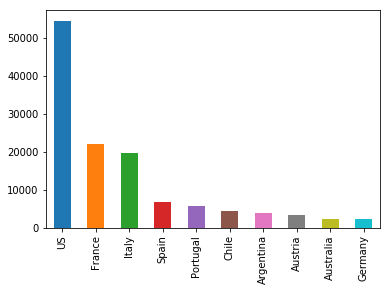

In [15]:
wine['country'].value_counts()[:10].plot(kind='bar')

#largest 10 wine producers in this dataset

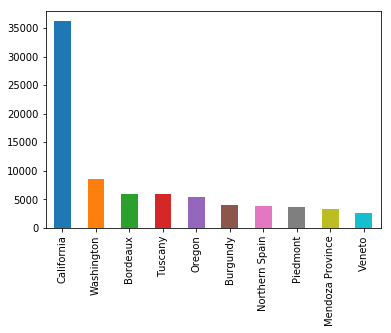

In [20]:
wine['province'].value_counts()[:10].plot(kind='bar')

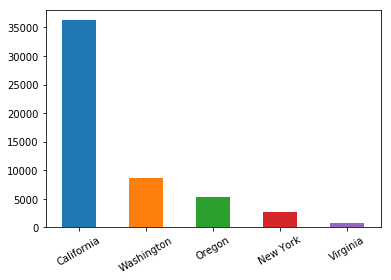

In [106]:
wine[wine['country']=='US']['province'].value_counts()[:5].plot(kind='bar',rot=30)

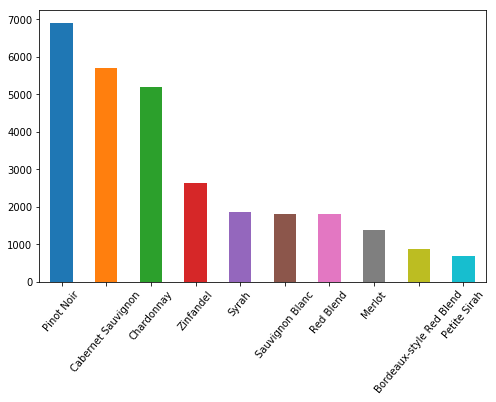

In [52]:
wine[wine['province']=='California']['variety'].value_counts()[:10].plot(kind='bar', figsize = (8,5), rot=50)

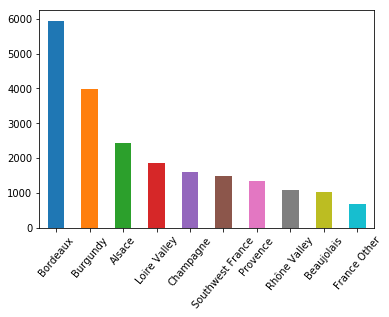

In [55]:
wine[wine['country']=='France']['province'].value_counts()[:10].plot(kind='bar',rot=50)

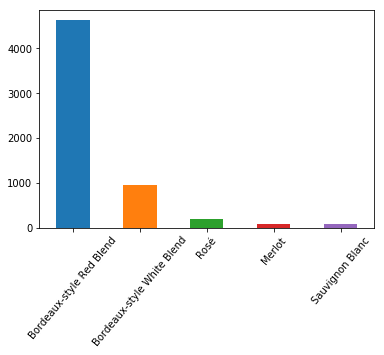

In [61]:
wine[wine['province']=='Bordeaux']['variety'].value_counts()[:5].plot(kind='bar',rot=50)

In [101]:
wine.variety.value_counts()[:10]

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
Riesling                     5189
Sauvignon Blanc              4967
Syrah                        4142
Rosé                         3564
Merlot                       3102
Name: variety, dtype: int64

In [17]:
wine_variety = wine.variety.unique()
len(wine_variety)

#708 unique wine types 

708

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


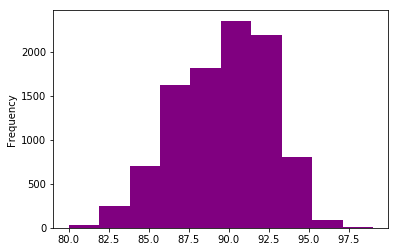

In [69]:
US_pinotnoir = wine[wine['country'] == 'US'][wine['variety']== 'Pinot Noir']
US_pinotnoir['points'].plot(kind='hist', color = 'purple')

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


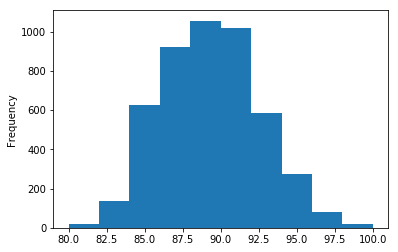

In [107]:
Fra_pinotnoir = wine[wine['country'] == 'France'][wine['variety']== 'Bordeaux-style Red Blend']
Fra_pinotnoir['points'].plot(kind='hist')

In [71]:
ita_pinotnoir = wine[wine['country'] == 'Italy'][wine['variety']== 'Pinot Noir']
esp_pinotnoir = wine[wine['country'] == 'Spain'][wine['variety']== 'Pinot Noir']

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5,1,'France Pinot Noir Wine Mag rankings')

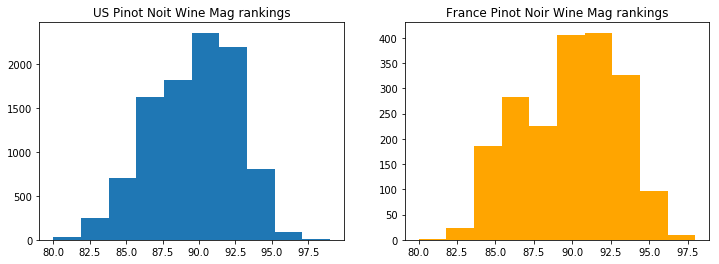

In [72]:
plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
plt.hist(US_pinotnoir['points'])
plt.title('US Pinot Noit Wine Mag rankings')

plt.subplot(1,2,2)
plt.hist(Fra_pinotnoir['points'], color = 'orange')
plt.title('France Pinot Noir Wine Mag rankings')


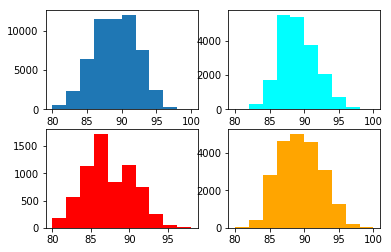

In [102]:
fig, axes = plt.subplots(nrows=2, ncols=2)


plt.subplot(2,2,1)
us_rating = wine[wine['country']== 'US']['points']
plt.hist(us_rating)

plt.subplot(2,2,2)
ita_rating = wine[wine['country']== 'Italy']['points']
plt.hist(ita_rating, color='aqua')

plt.subplot(2,2,3)
esp_rating = wine[wine['country']== 'Spain']['points']
plt.hist(esp_rating, color='red')

plt.subplot(2,2,4)
fra_rating = wine[wine['country']== 'France']['points']
plt.hist(fra_rating, color='orange')

plt.show()

In [73]:
wine.points.mean()

#Average rating of a bottle of wine on the list is 88

88.44713820775404

In [74]:
wine.points.min()

#lowest rated bottle is an 80

80

In [75]:
wine.points.describe()

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [76]:
wine[wine['points'] > 88].shape

(61271, 13)

In [77]:
wine[wine['points'] < 88].shape

(51493, 13)

In [78]:
tasters = wine['taster_name'].value_counts()
len(tasters)


19

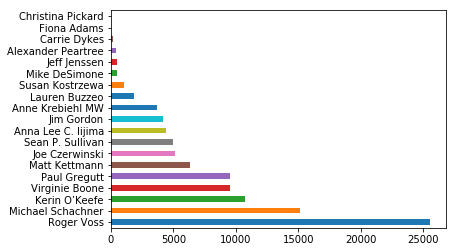

In [79]:
tasters.plot(kind='barh')
plt.show()

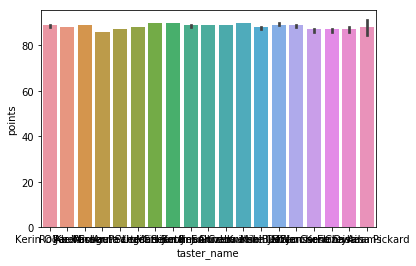

In [80]:
from numpy import median
ax = sns.barplot(x = 'taster_name', y='points', data=wine , estimator=median)

In [82]:
wine.groupby(['taster_name'])['points'].mean()

taster_name
Alexander Peartree    85.855422
Anna Lee C. Iijima    88.415629
Anne Krebiehl MW      90.562551
Carrie Dykes          86.395683
Christina Pickard     87.833333
Fiona Adams           86.888889
Jeff Jenssen          88.319756
Jim Gordon            88.626287
Joe Czerwinski        88.536235
Kerin O’Keefe         88.867947
Lauren Buzzeo         87.739510
Matt Kettmann         90.008686
Michael Schachner     86.907493
Mike DeSimone         89.101167
Paul Gregutt          89.082564
Roger Voss            88.708003
Sean P. Sullivan      88.755739
Susan Kostrzewa       86.609217
Virginie Boone        89.213379
Name: points, dtype: float64

In [83]:
wine['variety'].fillna(value = 'Unknown', inplace=True)

In [84]:
wine['variety'].isnull().value_counts()

False    129971
Name: variety, dtype: int64

In [85]:
wine[wine['country']]['variety'].sum()

ValueError: cannot index with vector containing NA / NaN values

In [86]:
wine['country'].isnull().value_counts()

False    129908
True         63
Name: country, dtype: int64

In [87]:
wine['country'].fillna(value = 'Unknown', inplace=True)
wine['country'].isnull().value_counts()

False    129971
Name: country, dtype: int64

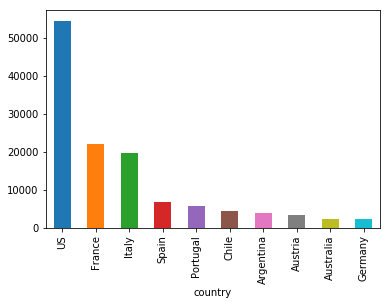

In [88]:
country_variety = wine.groupby('country')['variety'].size()
country_variety
country_variety.sort_values(ascending = False)[:10].plot.bar()



In [89]:
wine.title[:15]

#looking to pull year of vintage out of the title
#also inside parenthesis is the Region, can use this to fill in NaN values

0                     Nicosia 2013 Vulkà Bianco  (Etna)
1         Quinta dos Avidagos 2011 Avidagos Red (Douro)
2         Rainstorm 2013 Pinot Gris (Willamette Valley)
3     St. Julian 2013 Reserve Late Harvest Riesling ...
4     Sweet Cheeks 2012 Vintner's Reserve Wild Child...
5     Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...
6      Terre di Giurfo 2013 Belsito Frappato (Vittoria)
7                 Trimbach 2012 Gewurztraminer (Alsace)
8     Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...
9     Jean-Baptiste Adam 2012 Les Natures Pinot Gris...
10    Kirkland Signature 2011 Mountain Cuvée Caberne...
11              Leon Beyer 2012 Gewurztraminer (Alsace)
12    Louis M. Martini 2012 Cabernet Sauvignon (Alex...
13               Masseria Setteporte 2012 Rosso  (Etna)
14             Mirassou 2012 Chardonnay (Central Coast)
Name: title, dtype: object

In [90]:
wine['title'].str.split()[:4]

0               [Nicosia, 2013, Vulkà, Bianco, (Etna)]
1    [Quinta, dos, Avidagos, 2011, Avidagos, Red, (...
2    [Rainstorm, 2013, Pinot, Gris, (Willamette, Va...
3    [St., Julian, 2013, Reserve, Late, Harvest, Ri...
Name: title, dtype: object

In [91]:
wine['title'].str.split().str.get(1)[:4]

0      2013
1       dos
2      2013
3    Julian
Name: title, dtype: object

In [57]:
[int(s) for s in wine['title'].str.split()[4] if s.isdigit()]

[2012]

In [58]:
[int(s) for s in wine['title'].str.split()[5] if s.isdigit()]

[2011]

In [92]:
wine['title'] = wine['title'].astype(str)

In [93]:
wine['year'] = wine.title.str.extract('(\d{4})')

In [94]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012


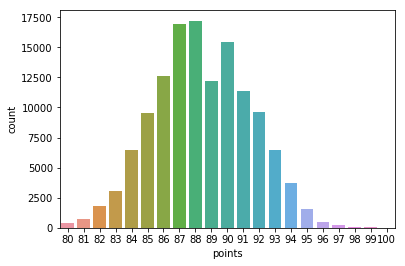

In [95]:
sns.countplot(wine['points']) 

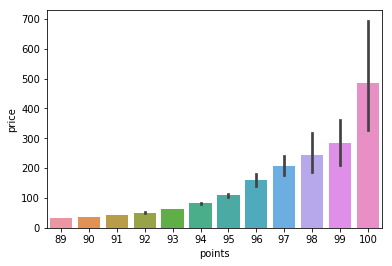

In [109]:
ax = sns.barplot(x="points", y="price", data=wine[wine['points']>88.5])

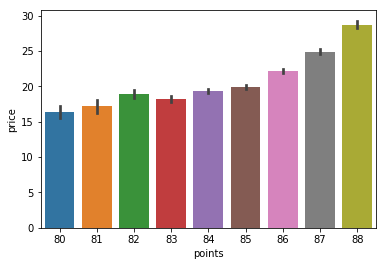

In [110]:
ax = sns.barplot(x="points", y="price", data=wine[wine['points']<88.5])

In [98]:
from datetime import datetime
wine['year'] = pd.to_datetime(wine.year, errors = 'coerce')
wine.info()
wine['year']= wine.year.dt.year

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 14 columns):
country                  129971 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129971 non-null object
winery                   129971 non-null object
year                     125331 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(11)
memory usage: 19.9+ MB


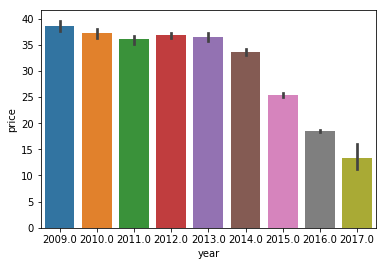

In [99]:
ax = sns.barplot(x="year", y="price", data=wine[wine['year']>2008])

### Working with NLP and textblob on wine description 

In [10]:
analysis.noun_phrases

WordList(['pineapple', 'lemon pith', 'orange blossom', 'semidry finish'])

In [4]:
wine.description[3]

'Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.'

In [5]:
review = wine.description[3]

In [121]:
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import sent_tokenize
import re

In [122]:
analysis = TextBlob(review)
analysis.sentiment.polarity

0.16666666666666669

In [123]:
analysis.sentiment.subjectivity

0.3333333333333333

In [124]:
analysis.tags

[('Pineapple', 'NNP'),
 ('rind', 'NN'),
 ('lemon', 'JJ'),
 ('pith', 'NN'),
 ('and', 'CC'),
 ('orange', 'NN'),
 ('blossom', 'NNS'),
 ('start', 'VBP'),
 ('off', 'IN'),
 ('the', 'DT'),
 ('aromas', 'NN'),
 ('The', 'DT'),
 ('palate', 'NN'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('bit', 'RB'),
 ('more', 'RBR'),
 ('opulent', 'JJ'),
 ('with', 'IN'),
 ('notes', 'NNS'),
 ('of', 'IN'),
 ('honey-drizzled', 'JJ'),
 ('guava', 'NN'),
 ('and', 'CC'),
 ('mango', 'NN'),
 ('giving', 'VBG'),
 ('way', 'NN'),
 ('to', 'TO'),
 ('a', 'DT'),
 ('slightly', 'RB'),
 ('astringent', 'JJ'),
 ('semidry', 'JJ'),
 ('finish', 'NN')]

In [125]:
analysis.sentences

[Sentence("Pineapple rind, lemon pith and orange blossom start off the aromas."),
 Sentence("The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.")]

In [126]:
analysis.sentiment

Sentiment(polarity=0.16666666666666669, subjectivity=0.3333333333333333)

In [135]:
analysis.classify

<bound method BaseBlob.classify of TextBlob("Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.")>

In [114]:
def polarity_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

In [115]:
wine['polarity'] = wine['description'].apply(polarity_calc)

In [130]:
wine['polarity'].head()

0    0.133333
1    0.220000
2    0.025000
3    0.166667
4    0.306667
Name: polarity, dtype: float64

In [155]:
def subjectivity_calc(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

In [156]:
wine['subjectivity'] = wine['description'].apply(subjectivity_calc)

In [157]:
wine['subjectivity'].head()

0    0.733333
1    0.460000
2    0.358333
3    0.333333
4    0.448718
Name: subjectivity, dtype: float64

In [160]:
analysis.classify

<bound method BaseBlob.classify of TextBlob("Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.")>

In [167]:
analysis.index

<bound method StringlikeMixin.index of TextBlob("Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.")>